# Multi-Class Prediction of Obesity Risk

In [53]:
from pathlib import Path
import json

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import optuna

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

## Carregamento dos Dados

In [2]:
# Dados de treinamento

data_train_path = Path('data/train.csv')

data_train = pd.read_csv(data_train_path)
data_train = data_train.drop(['id'], axis=1)

# Dataset original

data_original_path = Path('data/original_dataset/ObesityDataSet.csv')
data_original = pd.read_csv(data_original_path).drop_duplicates()

# Concatenação dos dados originais com os dados de treinamento

data_train_all = pd.concat([data_train, data_original], axis=0).drop_duplicates().reset_index(drop=True)

## Análise Exploratória

In [3]:
# Dados utilizados para a análise exploratória

eda_data = data_train.copy()

Significado Variáveis

- FAVC - Frequent consumption of high caloric food
- FCVC - Frequency of consumption of vegetables 
- NCP - Number of main meals
- CAEC - Consumption of food between meals
- CH20 - Consumption of water daily
- CALC - Consumption of alcohol
- SCC - Calories consumption monitoring
- FAF - Physical activity frequency 
- TUE - Time using technology devices
- MTRANS - Transportation used

### Análise Univariada

- Pode-se ver que o dataset não possúi dados faltantes 
- Dados duplicados já foram removidos ao serem carregados

In [4]:
eda_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          20758 non-null  object 
 1   Age                             20758 non-null  float64
 2   Height                          20758 non-null  float64
 3   Weight                          20758 non-null  float64
 4   family_history_with_overweight  20758 non-null  object 
 5   FAVC                            20758 non-null  object 
 6   FCVC                            20758 non-null  float64
 7   NCP                             20758 non-null  float64
 8   CAEC                            20758 non-null  object 
 9   SMOKE                           20758 non-null  object 
 10  CH2O                            20758 non-null  float64
 11  SCC                             20758 non-null  object 
 12  FAF                             

In [5]:
eda_data.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [6]:
eda_data.describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000
mean,23.841804,1.700245,87.887768,2.445908,2.761332,2.029418,0.981747,0.616756
std,5.688072,0.087312,26.379443,0.533218,0.705375,0.608467,0.838302,0.602113
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,20.000000,1.631856,66.000000,2.000000,3.000000,1.792022,0.008013,0.000000
50%,22.815416,1.700000,84.064875,2.393837,3.000000,2.000000,1.000000,0.573887
75%,26.000000,1.762887,111.600553,3.000000,3.000000,2.549617,1.587406,1.000000
max,61.000000,1.975663,165.057269,3.000000,4.000000,3.000000,3.000000,2.000000


#### Variáveis numéricas

##### Histogramas

In [7]:
sns.set_theme(style="darkgrid")

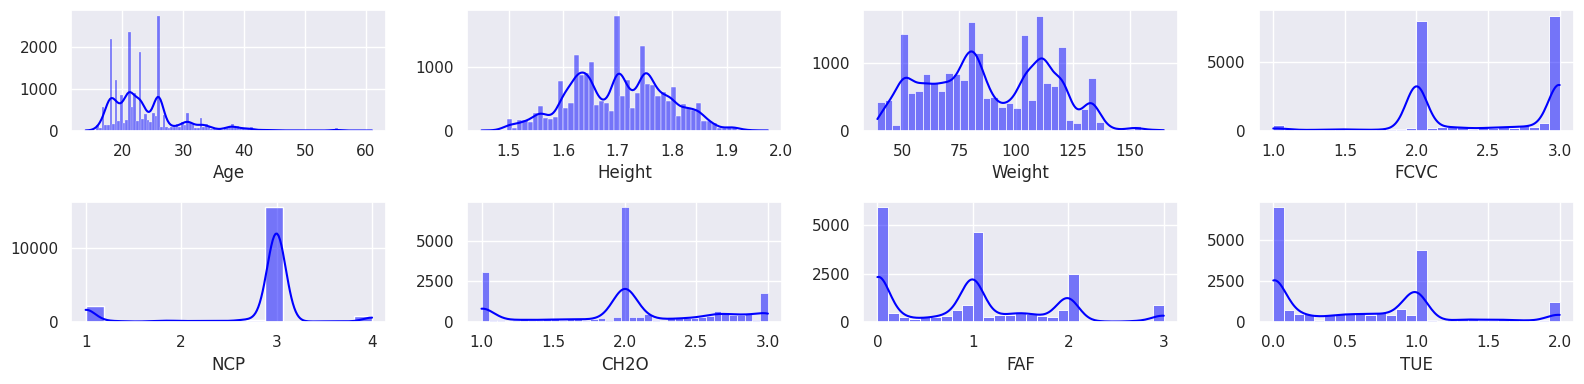

In [8]:
num_cols = eda_data.select_dtypes(include=['number']).columns.to_list()

fig, axes = plt.subplots(2, 4, figsize=(16, 4))

for ax, col in zip(np.ravel(axes), num_cols):
  sns.histplot(x=eda_data[col], ax=ax, kde=True, color='blue')
  ax.set_ylabel('')
  ax.grid(True)

plt.tight_layout() 
plt.show()

- Podemos ver que alguns atributos (EX: Age, NCP) possuem uma distribuição consideravelmente assimétrica. 
- Percebe-se que atributos como (FCVC, NCP, CH2O, FAF e TUE) possívelmente foram obtidos a partir de atributos categóricos. 

##### Boxplots

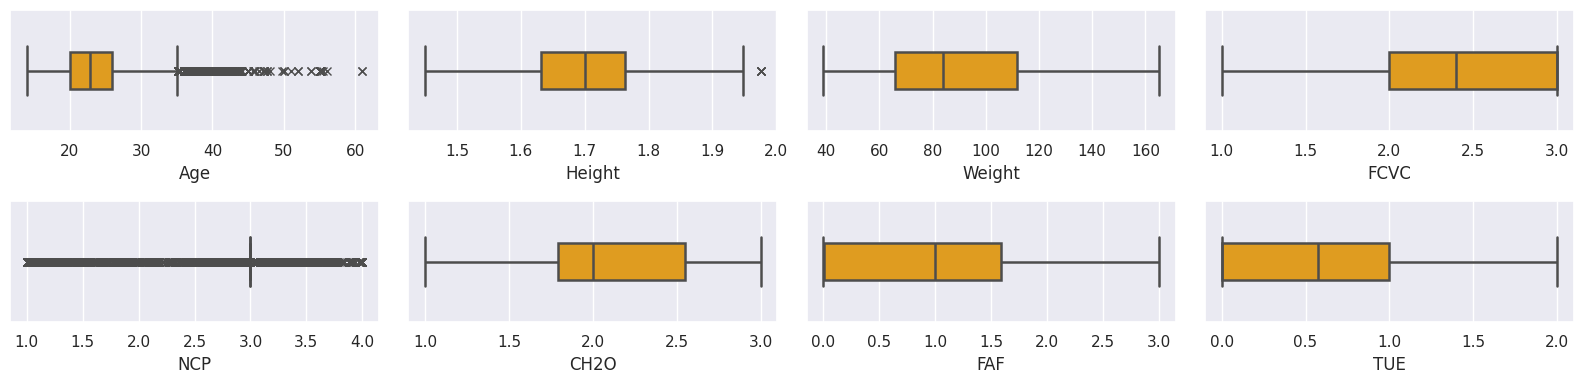

In [9]:
num_cols = eda_data.select_dtypes(include=['number']).columns.to_list()

fig, axes = plt.subplots(2, 4, figsize=(16, 4))

for ax, col in zip(np.ravel(axes), num_cols):
  sns.boxplot(x = eda_data[col], ax=ax, linewidth=1.8, widths=.3, color='orange', flierprops={"marker": "x"})

plt.tight_layout() 
plt.show()

#### Variáveis Categóricas

- Vemos que alguns atributos como (SMOKE e SCC) estão bem desbalanceados.

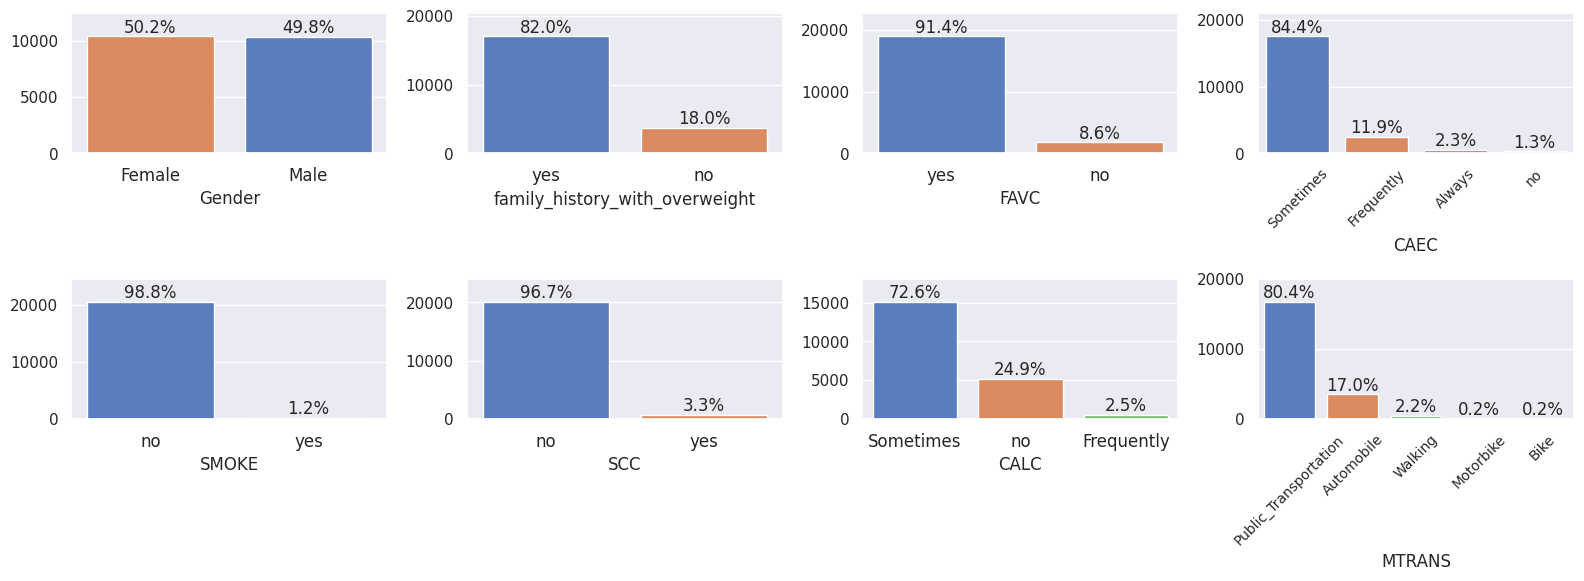

In [10]:
obj_cols = eda_data.select_dtypes(include=['object', 'category']).columns.to_list()

#palette_platform = sns.light_palette("green",5,reverse=True)

fig, axes = plt.subplots(2, 4, figsize=(16, 6))

for ax, col in zip(np.ravel(axes), obj_cols):
  sns.countplot(x=eda_data[col], ax=ax, order=eda_data[col].value_counts().index, hue=eda_data[col], palette='muted')
  total = eda_data[col].count()
  ax.set_ylabel('')
  ax.margins(y=0.2)

  for ct in ax.containers:
    ax.bar_label(ct, fmt=lambda x: f'{(x/total)*100:0.1f}%', fontsize=12)
  if col == 'MTRANS' or col == 'CAEC':
    ax.tick_params(axis='x', labelsize=10, labelrotation=45)
  else:
    ax.tick_params(axis='x', labelsize=12)

plt.tight_layout() 
plt.show()

##### Distribuição dos alvos

- Percebe-se um equilíbrio na quantidade de dados pertecente a cada classe alvo.

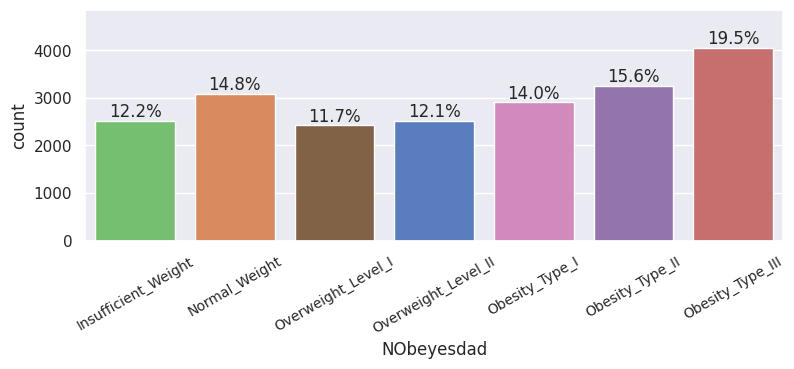

In [11]:
fig, ax = plt.subplots(figsize=(9,3))
total = eda_data['NObeyesdad'].count()
sns.countplot(x=eda_data['NObeyesdad'], 
              ax=ax,
              order=['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III'],
              hue=eda_data['NObeyesdad'], 
              palette='muted')

ax.margins(y=0.2)

for ct in ax.containers:
    ax.bar_label(ct, fmt=lambda x: f'{(x/total)*100:0.1f}%', fontsize=12)

plt.xticks(rotation=30, fontsize=10)
plt.show()

### Análise Bivariada

#### Atributos Numéricos x Alvo

- Percebe-se uma certa correlação entre a idade e o peso em relação ao atributo alvo.
- Para os outros dados não foi possível verificar uma relação de forma visual.

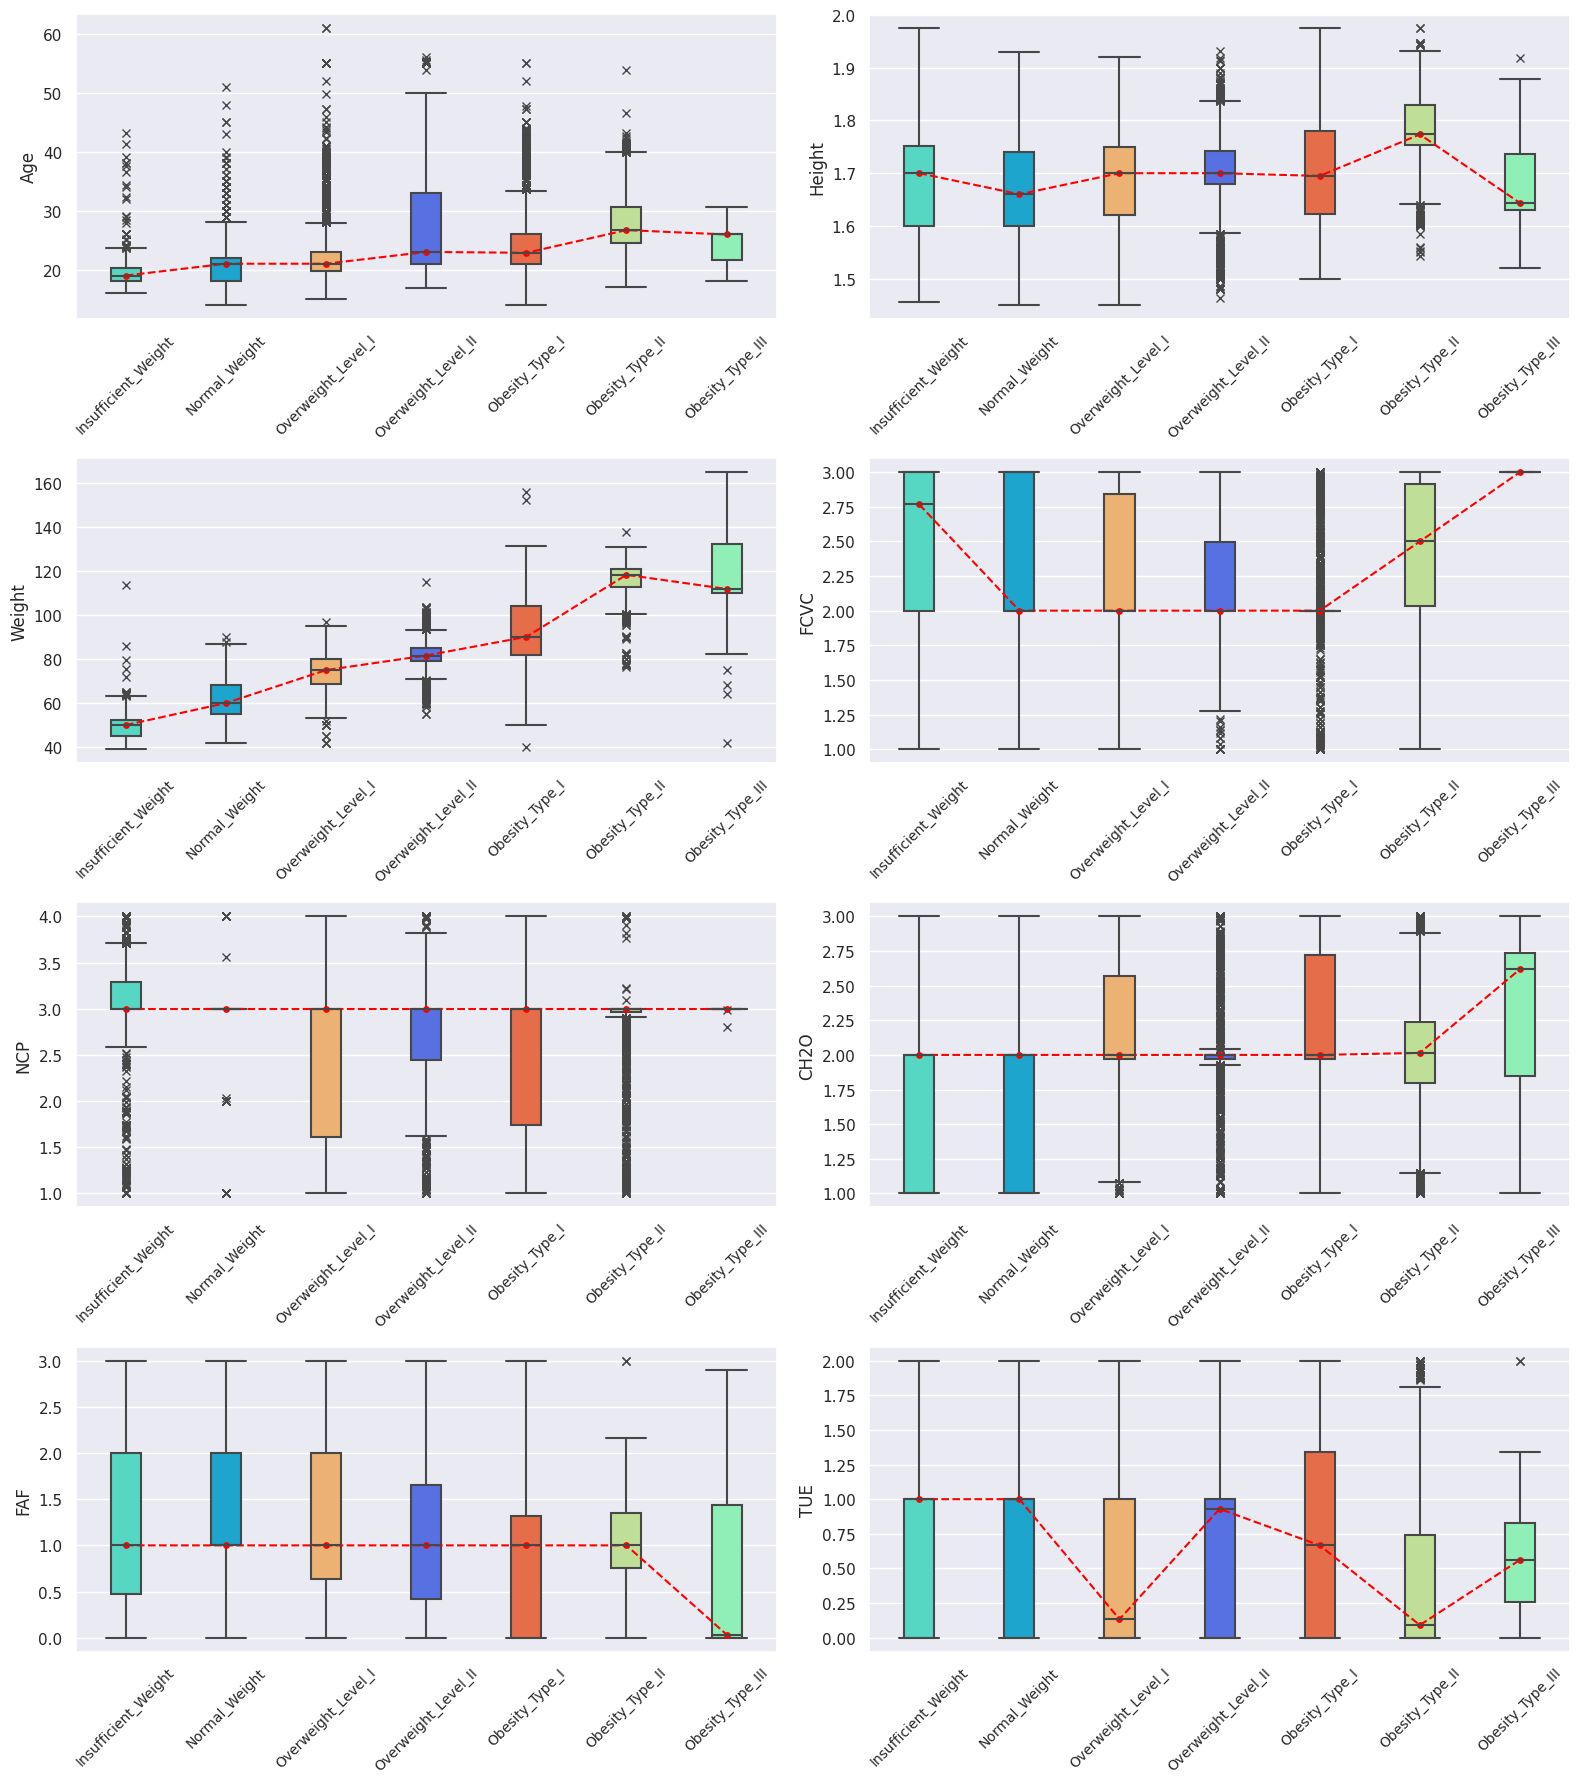

In [12]:
num_cols = eda_data.select_dtypes(include=['number']).columns.to_list()

fig, axes = plt.subplots(4, 2, figsize=(16, 18))

for ax, col in zip(np.ravel(axes), num_cols):
  sns.boxplot(x=eda_data['NObeyesdad'], y=eda_data[col], ax=ax, 
              linewidth=1.5, widths=.3, palette='rainbow', hue=eda_data['NObeyesdad'], legend=False, flierprops={"marker": "x"},
              order=['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III'])
  sns.pointplot(x='NObeyesdad', y=col, data=eda_data[['NObeyesdad', col]].groupby('NObeyesdad', as_index=False).median(), ax=ax, linestyles='--', color='red', linewidth=1.5)
  ax.tick_params(axis='x', labelsize=10, labelrotation=45)
  ax.set_xlabel('')
plt.tight_layout() 
plt.show()

#### Atributos Categóricos x Alvo

- Vemos que para o tipo Obesity_Type_II somente tem homens e para o tipo Obesity_Type_III praticamente só tem mulhers.
- Vemos um aumento gradual no número do histórico de sobrepeso na família conforme o nível de sobrepeso aumenta. 

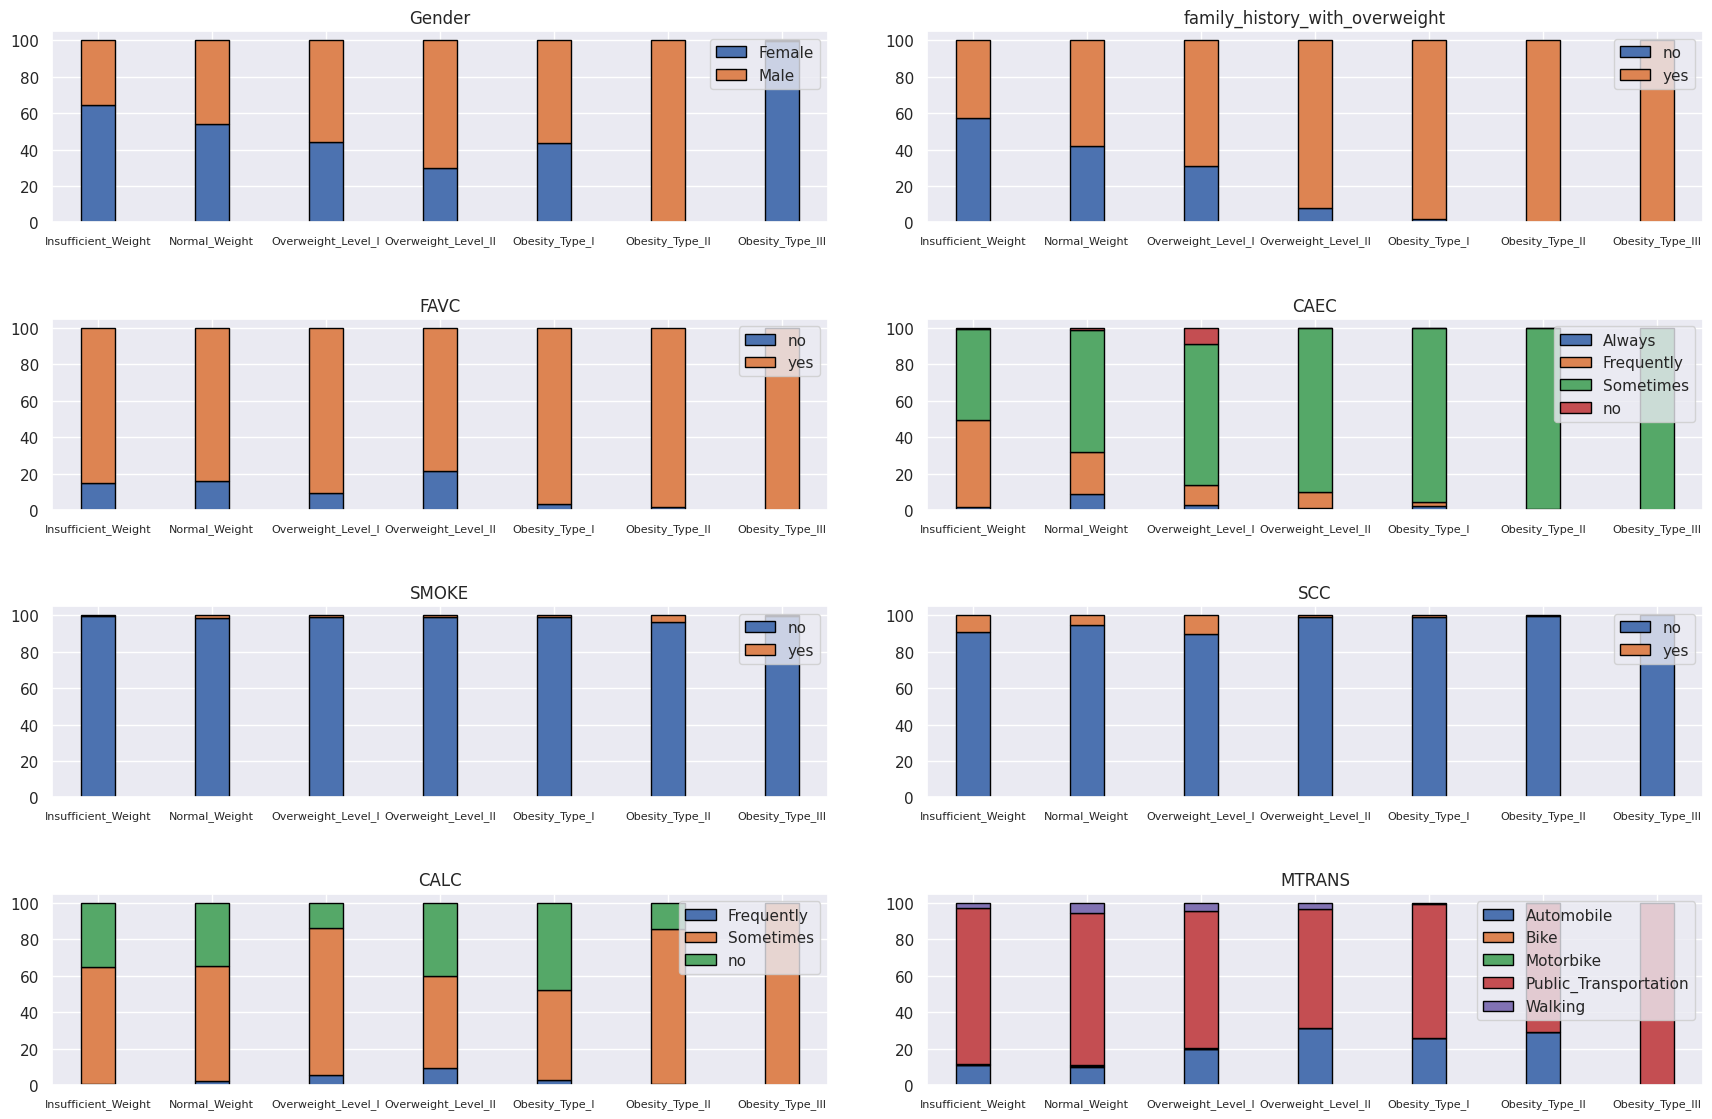

In [13]:
obj_cols = eda_data.select_dtypes(include=['object', 'category']).columns.to_list()
target_order = ['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III']

fig, axes = plt.subplots(4, 2, figsize=(18, 12))

for ax, col in zip(np.ravel(axes), obj_cols):
    
    a = (eda_data.groupby('NObeyesdad')[col].value_counts(normalize=True).mul(100).round(2).unstack())
    a.loc[target_order].plot(kind = "bar", stacked = True, ax = ax, width = 0.3, edgecolor = "black")
    ax.tick_params(axis='x', labelsize=8, labelrotation=0)
    ax.legend(loc='upper right')
    ax.set_title(col)
    ax.set_xlabel('')
    
plt.subplots_adjust(bottom=0.5, top=1)
plt.tight_layout(pad=3) 
plt.show()

#### Atributos (FCVC, NCP, CH2O, FAF e TUE) transformados em categóricos ordinais.

In [14]:
eda_data_num_to_cat = eda_data.copy()

eda_data_num_to_cat['FCVC'] = pd.cut(x=eda_data_num_to_cat['FCVC'], bins=[0.5, 1.5, 2.5, 3.0], labels=['Sometimes', 'Frequently', 'Always']) 
eda_data_num_to_cat['NCP'] = pd.cut(x=eda_data_num_to_cat['NCP'], bins=[0.5, 1.5, 2.5, 3.5, 4.0], labels=['One', 'Two', 'Three', 'Four']) 
eda_data_num_to_cat['CH2O'] = pd.cut(x=eda_data_num_to_cat['CH2O'], bins=[0.5, 1.5, 2.5, 3.0], labels=['One', 'Two', 'Three']) 
eda_data_num_to_cat['FAF'] = pd.cut(x=eda_data_num_to_cat['FAF'], bins=[-0.5, 0.5, 1.5, 2.5, 3.0], labels=['No', 'Sometimes', 'Frequently', 'Always']) 
eda_data_num_to_cat['TUE'] = pd.cut(x=eda_data_num_to_cat['TUE'], bins=[-0.5, 0.5, 1.5, 2.0],labels=['Sometimes', 'Frequently', 'Always'])

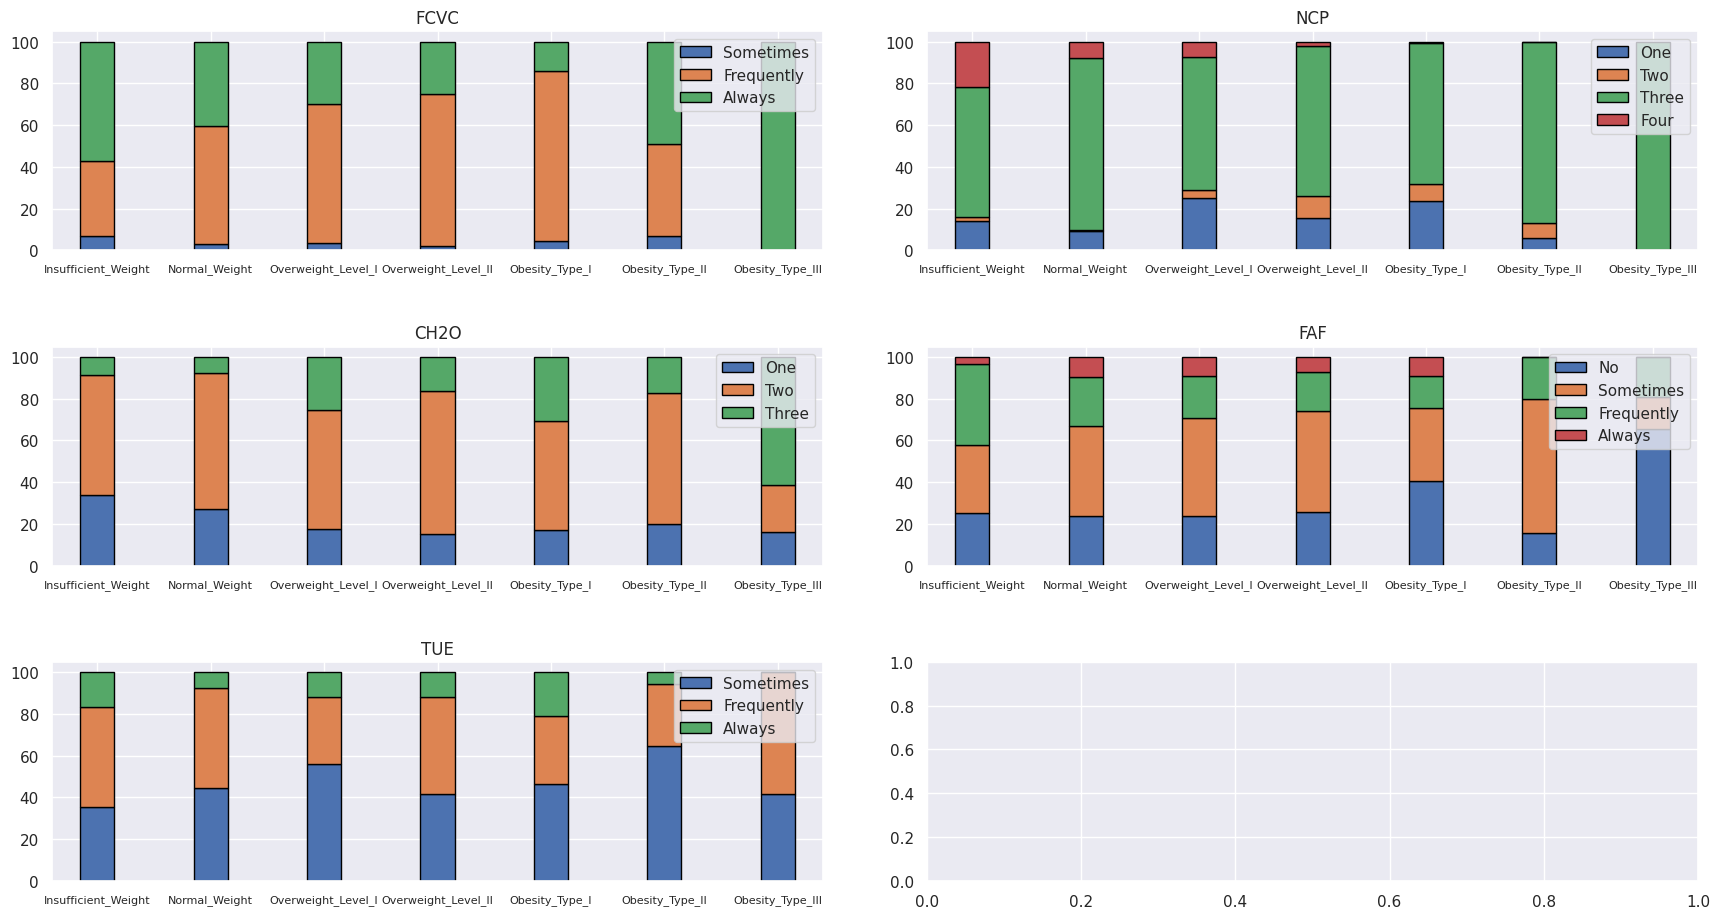

In [15]:
obj_cols = ['FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
target_order = ['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III']

fig, axes = plt.subplots(3, 2, figsize=(18, 10))

for ax, col in zip(np.ravel(axes), obj_cols):
    
    a = (eda_data_num_to_cat.groupby('NObeyesdad')[col].value_counts(normalize=True).mul(100).round(2).unstack())
    a.loc[target_order].plot(kind = "bar", stacked = True, ax = ax, width = 0.3, edgecolor = "black")
    ax.tick_params(axis='x', labelsize=8, labelrotation=0)
    ax.legend(loc='upper right')
    ax.set_title(col)
    ax.set_xlabel('')
    
plt.subplots_adjust(bottom=0.5, top=1)
plt.tight_layout(pad=3) 
plt.show()

#### Correlação linear entre variáveis numéricas

- Notamos em geral uma baixa correlação linear entre as variáveis numéricas.
- As correlações de maior destaque são entre o peso e a altura e entre o consumo de água e o peso.

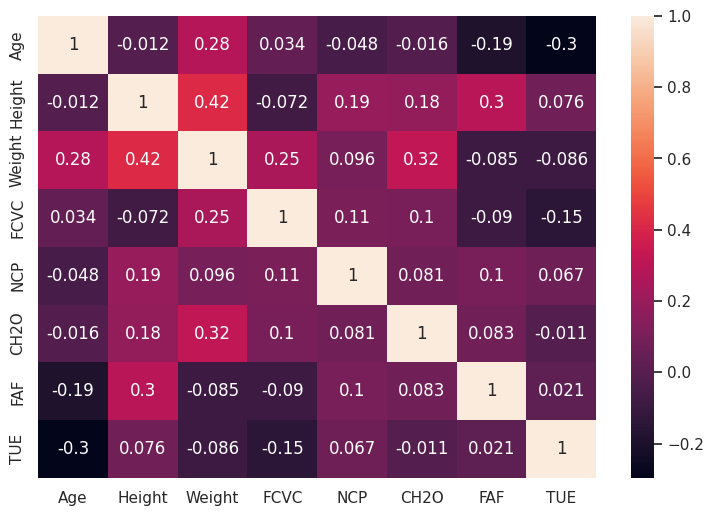

In [16]:
num_cols = eda_data.select_dtypes(include=['number']).columns.to_list()

fig, ax = plt.subplots(figsize=(9,6)) 
sns.heatmap(eda_data[num_cols].corr(), annot=True, ax=ax)
plt.show()

- Matriz de correlação entre algumas variáveis numéricas

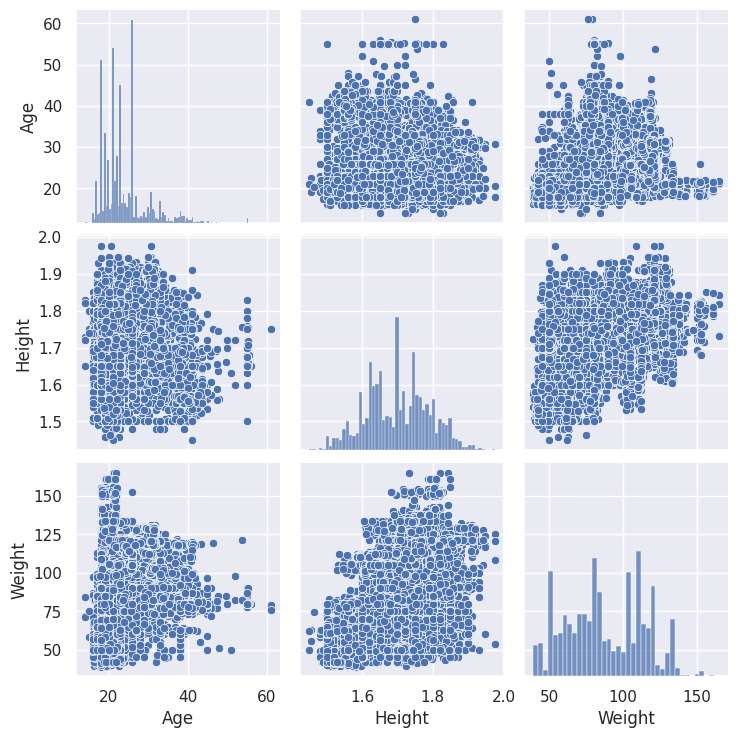

In [17]:
#num_cols = eda_data.select_dtypes(include=['number']).columns.to_list()
num_cols = ['Age', 'Height', 'Weight']

sns.pairplot(data=eda_data[num_cols])
plt.show()

## Pré-processamento dos dados

Serão testados algumas configurações de pré-processamento:

- Configuração 1: Todos os atributos sem transformações de tipo e sem criação ou remoção de atributos; Atributos numéricos escalados com o "RobustScaler" que usa a mediana e o IQR para escalar os dados; Atributos categóricos ('Gender', 'family_history_with_overweight','FAVC', 'SMOKE', 'SCC', 'MTRANS') para one-hot e atributos categóricos ordinais ('CAEC', 'CALC') mapeados para inteiros.

- Configuração 2: Será testado a aplicação da normalização pela média e desvio padrão (z-score).

- Configuração 3: Será testado a aplicação do one-hot para todos os atributos categóricos.

- Configuração 4: Criação do atributo "IMC" = peso/altura^2

- Configuração 5: Exclusão dos atributos "SMOKE" e "SCC"

- Configuração 6: Transformação dos atributos ['FCVC', 'NCP', 'CH2O', 'FAF', 'TUE'] em categóricos ordinais.

#### Pipelines de transformação correspondendo a cada configuração de pré-processamento.

In [18]:
num_cols = data_train.select_dtypes(include=['number']).columns.to_list()
oh_cols = ['Gender', 'family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC', 'MTRANS']
ordinal_cols = ['CAEC', 'CALC']

caec_mapping = ['no', 'Sometimes', 'Frequently', 'Always']
calc_mapping = ['no', 'Sometimes', 'Frequently']

In [19]:
# Configuração 1: One-Hot/Ordinal/RobustScaler

ct1 = ColumnTransformer(
    [('oh', OneHotEncoder(sparse_output=False, drop='if_binary', handle_unknown='ignore'), oh_cols),
     ('ord', OrdinalEncoder(categories=[caec_mapping, calc_mapping], handle_unknown='use_encoded_value', unknown_value=-1), ordinal_cols),
     ('rb', RobustScaler(), num_cols)],
     remainder='passthrough'
).set_output(transform='pandas')

ct2 = ColumnTransformer(
    [('rb', RobustScaler(), ['ord__CAEC', 'ord__CALC'])],
    remainder='passthrough'
).set_output(transform='pandas')

pipe1 = Pipeline(
    [('ct1', ct1), ('ct2', ct2)]
).set_output(transform='pandas')

In [20]:
# Configuração 2: One-Hot/Ordinal/StandardScaler

ct1 = ColumnTransformer(
    [('oh', OneHotEncoder(sparse_output=False, drop='if_binary', handle_unknown='ignore'), oh_cols),
     ('ord', OrdinalEncoder(categories=[caec_mapping, calc_mapping], handle_unknown='use_encoded_value', unknown_value=-1), ordinal_cols),
     ('std', StandardScaler(), num_cols)],
     remainder='passthrough'
).set_output(transform='pandas')

ct2 = ColumnTransformer(
    [('std', StandardScaler(), ['ord__CAEC', 'ord__CALC'])],
    remainder='passthrough'
).set_output(transform='pandas')

pipe2 = Pipeline(
    [('ct1', ct1), ('ct2', ct2)]
).set_output(transform='pandas')

In [21]:
# Configuração 3: One-Hot/RobustScaler

ct1 = ColumnTransformer(
    [('oh', OneHotEncoder(sparse_output=False, drop='if_binary', handle_unknown='ignore'), oh_cols+ordinal_cols),
     ('rb', RobustScaler(), num_cols)],
     remainder='passthrough'
).set_output(transform='pandas')

pipe3 = Pipeline(
    [('ct1', ct1)]
).set_output(transform='pandas')

In [22]:
# Configuração 4: One-Hot/Ordinal/RobustScaler/IMC

num_cols_imc = num_cols + ['IMC']

ct1 = ColumnTransformer(
    [('oh', OneHotEncoder(sparse_output=False, drop='if_binary', handle_unknown='ignore'), oh_cols),
     ('ord', OrdinalEncoder(categories=[caec_mapping, calc_mapping], handle_unknown='use_encoded_value', unknown_value=-1), ordinal_cols),
     ('rb', RobustScaler(), num_cols_imc)],
     remainder='passthrough'
).set_output(transform='pandas')

ct2 = ColumnTransformer(
    [('rb', RobustScaler(), ['ord__CAEC', 'ord__CALC'])],
    remainder='passthrough'
).set_output(transform='pandas')

pipe4 = Pipeline(
    [('ct1', ct1), ('ct2', ct2)]
).set_output(transform='pandas')

In [23]:
# Configuração 5: One-Hot/Ordinal/RobustScale/ removidos SMOKE e SCC

oh_removed_cols = oh_cols.copy()
oh_removed_cols.remove('SMOKE')
oh_removed_cols.remove('SCC')

ct1 = ColumnTransformer(
    [('oh', OneHotEncoder(sparse_output=False, drop='if_binary', handle_unknown='ignore'), oh_removed_cols),
     ('ord', OrdinalEncoder(categories=[caec_mapping, calc_mapping], handle_unknown='use_encoded_value', unknown_value=-1), ordinal_cols),
     ('rb', RobustScaler(), num_cols)],
     remainder='passthrough'
).set_output(transform='pandas')

ct2 = ColumnTransformer(
    [('rb', RobustScaler(), ['ord__CAEC', 'ord__CALC'])],
    remainder='passthrough'
).set_output(transform='pandas')

pipe5 = Pipeline(
    [('ct1', ct1), ('ct2', ct2)]
).set_output(transform='pandas')

In [24]:
# Configuração 6: One-Hot/Ordinal/RobustScale/ 'CAEC', 'CALC', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE' como atributos categóricos ordinais

num_cols = ['Age', 'Height', 'Weight']
oh_cols = ['Gender', 'family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC', 'MTRANS']
ordinal_cols = ['CAEC', 'CALC', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

caec_mapping = ['no', 'Sometimes', 'Frequently', 'Always']
calc_mapping = ['no', 'Sometimes', 'Frequently']
fcvc_mapping = ['Sometimes', 'Frequently', 'Always']
ncp_mapping = ['One', 'Two', 'Three', 'Four']
ch2o_mapping = ['One', 'Two', 'Three']
faf_mapping = ['No', 'Sometimes', 'Frequently', 'Always']
tue_mapping = ['Sometimes', 'Frequently', 'Always']

ct1 = ColumnTransformer(
    [('oh', OneHotEncoder(sparse_output=False, drop='if_binary', handle_unknown='ignore'), oh_cols),
     ('ord', OrdinalEncoder(categories=[caec_mapping, calc_mapping, fcvc_mapping, ncp_mapping, ch2o_mapping, faf_mapping, tue_mapping], handle_unknown='use_encoded_value', unknown_value=-1), ordinal_cols),
     ('rb', RobustScaler(), num_cols)],
     remainder='passthrough'
).set_output(transform='pandas')

ct2 = ColumnTransformer(
    [('rb', RobustScaler(), ['ord__CAEC', 'ord__CALC', 'ord__FCVC', 'ord__NCP', 'ord__CH2O', 'ord__FAF', 'ord__TUE'])],
    remainder='passthrough'
).set_output(transform='pandas')

pipe6 = Pipeline(
    [('ct1', ct1), ('ct2', ct2)]
).set_output(transform='pandas')

## Treinamento

- Todos os modelos e configurações foram testadas utilizando um esquema de 10 Fold Cross Validation.

In [25]:
x = data_train_all.drop('NObeyesdad', axis=1)
y = data_train_all['NObeyesdad']


# Mapeamento dos valores alvo para inteiros.
labels_mapping = {'Insufficient_Weight':0,
                  'Normal_Weight':1,
                  'Overweight_Level_I':2,
                  'Overweight_Level_II':3,
                  'Obesity_Type_I':4,
                  'Obesity_Type_II':5,
                  'Obesity_Type_III':6}

inverse_labels_mapping = {v:k for k,v in labels_mapping.items()}

y = y.map(labels_mapping)

In [26]:
# Função para calcular a média dos resultados do cross-validation
def get_results_avg(cv_results):

    prec = [0] * 7
    rec = [0] * 7
    f1 = [0] * 7
    acc = []

    for f in cv_results:
        for i in range(7):
            prec[i] += f[str(i)]['precision']
            rec[i] += f[str(i)]['recall']
            f1[i] += f[str(i)]['f1-score']
        acc.append(f['accuracy'])

    prec = [k/len(cv_results) for k in prec]
    rec = [k/len(cv_results) for k in rec]
    f1 = [k/len(cv_results) for k in f1]

    results = {}
    for i in range(7):
        results[str(i)] = {'precision': prec[i], 'recall': rec[i], 'f1-score': f1[i]}
    results['accuracy'] = sum(acc)/len(cv_results)

    return results

# Função que realiza a validação cruzada
def kfoldcrossval(x, y, classifier, data_pipeline, n_splits=10, random_state=42):

    results_per_fold = []
    confusion_matrix_per_fold = []
    results_per_fold_train = []
    confusion_matrix_per_fold_train = []

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for train_index, test_index in skf.split(x, y):
        
        x_train, y_train = x.iloc[train_index], y.iloc[train_index]
        x_test, y_test = x.iloc[test_index], y.iloc[test_index]

        x_train = data_pipeline.fit_transform(x_train)
        x_test = data_pipeline.transform(x_test)

        classifier.fit(x_train, y_train)

        y_pred = classifier.predict(x_test)
        y_pred_train = classifier.predict(x_train)

        report_dict = classification_report(y_test, y_pred, output_dict=True)
        report_dict_train = classification_report(y_train, y_pred_train, output_dict=True)

        results_per_fold.append(report_dict)
        results_per_fold_train.append(report_dict_train)
        
        confusion_matrix_per_fold.append(confusion_matrix(y_test, y_pred, normalize='true'))
        confusion_matrix_per_fold_train.append(confusion_matrix(y_train, y_pred_train, normalize='true'))
    
    results_avg = get_results_avg(results_per_fold)
    avg_confusion_matrix = np.mean(np.array(confusion_matrix_per_fold), axis=0)

    results_avg_train = get_results_avg(results_per_fold_train)
    avg_confusion_matrix_train = np.mean(np.array(confusion_matrix_per_fold_train), axis=0)

    results = {'fold_results': results_per_fold,
               'avg_results': results_avg,
               'features_names': data_pipeline.get_feature_names_out(),
               'avg_confusion_matrix': avg_confusion_matrix,
               'avg_results_train': results_avg_train,
               'avg_confusion_matrix_train': avg_confusion_matrix_train,
               'confusion_matrix_per_fold': confusion_matrix_per_fold,
               'confusion_matrix_per_fold_train': confusion_matrix_per_fold_train}

    return results

#### Teste dos modelos

- Primeiramente foram testados diversos modelos com seus parâmetros padrões.
- Foram testados Naive Bayes, SVM, Random Forest, XGB, LGBM 

In [28]:
models_results_list = []

gnb = GaussianNB()
svm = SVC()
rf = RandomForestClassifier(verbose=0, random_state=42)
xgb = XGBClassifier(random_state=42)
lgbm = LGBMClassifier(objective="multiclass", metric="multi_logloss", random_state=42, verbose=-1)

classifiers = [gnb, svm, rf, xgb, lgbm]
names = ['Naive Bayes', 'SVM', 'Random Forest', 'XGB', 'LGBM']

for classifier, name in zip(classifiers, names):
    results = kfoldcrossval(x, y, classifier, data_pipeline=pipe1, n_splits=10, random_state=42)
    models_results_list.append(results)
    print(f'Acc {name}: {results['avg_results']['accuracy']}')

Acc Naive Bayes: 0.6144887275960252
Acc SVM: 0.8818116130861823
Acc Random Forest: 0.9057123093961609
Acc XGB: 0.9110963528992478
Acc LGBM: 0.9121907322176535


- O modelo LGBM apresentou o melhor resultado de acurácia e foi o escolhido para ser utilizado.

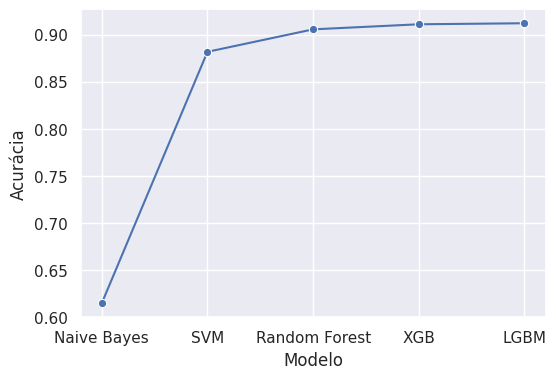

In [29]:
models = ['Naive Bayes', 'SVM', 'Random Forest', 'XGB', 'LGBM']

models_results_plot = {'Modelo': [], 'Acurácia': []}

for model, name in zip(models_results_list, models):
    models_results_plot['Modelo'].append(name)
    models_results_plot['Acurácia'].append(model['avg_results']['accuracy'])

models_results_df = pd.DataFrame(models_results_plot)

fig, axes = plt.subplots(figsize=(6, 4))
sns.lineplot(data=models_results_df, x='Modelo', y='Acurácia', markers=True, marker='o', ax=axes)
plt.show()

- Box-plot com os resultados dos modelos na validação cruzada.
- Vemos que o modelo de Naive Bayes apresenta a menor acurácia e a maior variabilidade entre os resultados da validação cruzada.

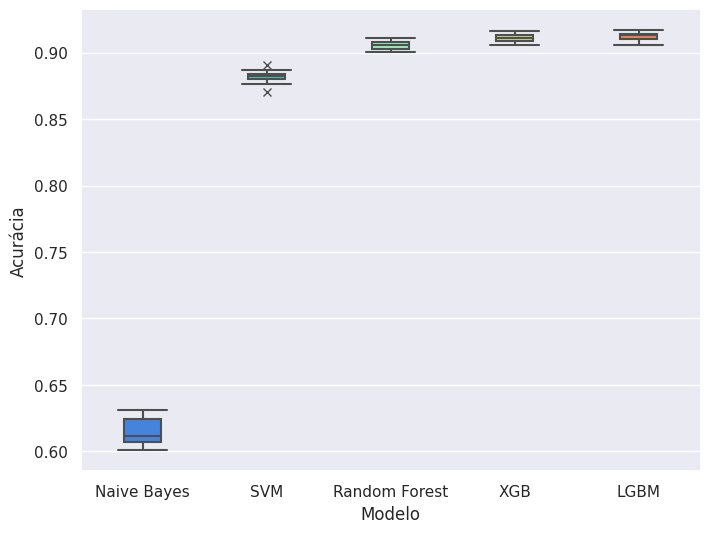

In [30]:
models = ['Naive Bayes', 'SVM', 'Random Forest', 'XGB', 'LGBM']

models_results_plot = {'Modelo': [], 'Acurácia': []}

for model, name in zip(models_results_list, models):
    for fold in model['fold_results']:
        models_results_plot['Modelo'].append(name)
        models_results_plot['Acurácia'].append(fold['accuracy'])

models_results_df = pd.DataFrame(models_results_plot)

fig, axes = plt.subplots(figsize=(8, 6))

sns.boxplot(data=models_results_df, x='Modelo', y='Acurácia',  
              linewidth=1.5, widths=.3, palette='rainbow', hue='Modelo', flierprops={"marker": "x"},
              order=['Naive Bayes', 'SVM', 'Random Forest', 'XGB', 'LGBM'], ax=axes)
plt.show()

#### Hiperparâmetros do modelo escolhido (LGBM)

- Foi utilizado o framework Optuna para a definição dos hiperparâmetros.
- Optuna utiliza uma otimização bayesiana na procura dos melhores hiperparâmetros.
- Foram definidos espaços de possíveis valores para alguns parâmetros e foram testadas 30 configurações de parâmetros diferentes.
- Hiperparâmetros foram otimizados para a máxima acurácia.
- Para o pré-processamento dos dados foi utilizada a configuração 1 de pré-processamento.
- Para a busca dos hiperparâmetros os modelos foram validados através de 5-fold cross validation.

In [ ]:
def kfoldcrossval_opt(x, y, classifier, data_pipeline, n_splits=10, random_state=42):

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    accs = []
    for train_index, test_index in skf.split(x, y):
        
        x_train, y_train = x.iloc[train_index], y.iloc[train_index]
        x_test, y_test = x.iloc[test_index], y.iloc[test_index]

        x_train = data_pipeline.fit_transform(x_train)
        x_test = data_pipeline.transform(x_test)
        
        classifier.fit(x_train, y_train)
        
        y_pred = classifier.predict(x_test)
        accs.append(accuracy_score(y_test, y_pred))

    acc = sum(accs)/n_splits
    return acc

# Função que define os possíveis valores de parâmetros para serem testados pelo otimizador.
def objective(trial):

    params = {
        "objective": "multiclass",
        "metric": "multi_logloss",
        "n_estimators": 1000,
        "verbose": -1,
        "bagging_freq": 1,
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 1024),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    model = LGBMClassifier(**params)
    acc = kfoldcrossval_opt(x, y, model, data_pipeline=pipe1, n_splits=5)
    return acc

# Objetivo é maximizar a acurácia
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)
print('Best hyperparameters:', study.best_params)
print('Best Acc:', study.best_value)

# Best hyperparameters: {'learning_rate': 0.008761898503537986, 'num_leaves': 21, 'subsample': 0.5253186918479049, 'colsample_bytree': 0.5446690373879486, 'min_data_in_leaf': 66}
# Best Acc: 0.9171370431543571

In [ ]:
# Melhores parâmetros obtidos

best_params = {"objective": "multiclass",
               "metric": "multi_logloss",
               "n_estimators": 1000,
               "verbose": -1,
               "bagging_freq": 1,
               'learning_rate': 0.008761898503537986, 
               'num_leaves': 21, 
               'subsample': 0.5253186918479049, 
               'colsample_bytree': 0.5446690373879486, 
               'min_data_in_leaf': 66}

#### Teste dos tipos de pré-processamento

- Foram testadas todas as configuração de pré-processamento definidas anteriormente. 
- Foi utilizado o modelo LGBM com os parâmetros definidos no passo anterior.

In [27]:
x_imc = x.copy()
x_imc['IMC'] = x_imc['Weight'] / (x_imc['Height']**2)

x_drop = x.drop(['SMOKE', 'SCC'], axis=1)

x_cat = x.copy()
x_cat['FCVC'] = pd.cut(x=x_cat['FCVC'], bins=[0.5, 1.5, 2.5, 3.0], labels=['Sometimes', 'Frequently', 'Always']) 
x_cat['NCP'] = pd.cut(x=x_cat['NCP'], bins=[0.5, 1.5, 2.5, 3.5, 4.0], labels=['One', 'Two', 'Three', 'Four']) 
x_cat['CH2O'] = pd.cut(x=x_cat['CH2O'], bins=[0.5, 1.5, 2.5, 3.0], labels=['One', 'Two', 'Three']) 
x_cat['FAF'] = pd.cut(x=x_cat['FAF'], bins=[-0.5, 0.5, 1.5, 2.5, 3.0], labels=['No', 'Sometimes', 'Frequently', 'Always']) 
x_cat['TUE'] = pd.cut(x=x_cat['TUE'], bins=[-0.5, 0.5, 1.5, 2.0],labels=['Sometimes', 'Frequently', 'Always'])

datasets = [(x, y), (x, y), (x, y), (x_imc, y), (x_drop, y), (x_cat, y)]
pipelines = [pipe1, pipe2, pipe3, pipe4, pipe5, pipe6]

In [28]:
import warnings
warnings.filterwarnings('ignore')

results_list = []

model_params = {"objective": "multiclass",
                "metric": "multi_logloss",
                "n_estimators": 1000,
                "verbose": -1,
                "bagging_freq": 1,
                'learning_rate': 0.008761898503537986, 
                'num_leaves': 21, 
                'subsample': 0.5253186918479049, 
                'colsample_bytree': 0.5446690373879486, 
                'min_data_in_leaf': 66}

for i, ((f,t), pipe)  in enumerate(zip(datasets, pipelines),1):
    
    lgbm = LGBMClassifier(**model_params)
    results = kfoldcrossval(f, t, lgbm, data_pipeline=pipe, n_splits=10, random_state=42)
    results_list.append(results)

    print(f'********************  Conf {i}  ************************')
    print(f'ACC test: {results['avg_results']['accuracy']}')
    print(f'ACC train: {results['avg_results_train']['accuracy']}')

********************  Conf 1  ************************
ACC test: 0.9171370431543571
ACC train: 0.9465139460222473
********************  Conf 2  ************************
ACC test: 0.9169620076107409
ACC train: 0.9464604398187267
********************  Conf 3  ************************
ACC test: 0.9170056179990572
ACC train: 0.9473456353751966
********************  Conf 4  ************************
ACC test: 0.9168304100066298
ACC train: 0.9486199234526019
********************  Conf 5  ************************
ACC test: 0.9166991956220996
ACC train: 0.9461151211437467
********************  Conf 6  ************************
ACC test: 0.9153424066956125
ACC train: 0.9400841441344603


- Podemos ver que a primeira configuração de pré-processamento apresentou o melhor resultado, portanto foi a escolhida.
- É interessante notar que a adição do atributo "IMC" (Conf 4) não melhorou os resultados do modelo, inclusíve foram obtidos resultados piores. Acredito que o modelo já consiga "aprender" essa relação.

In [26]:
# Salvar resultados

json_results = []

for r in results_list:
    d = {k:r[k] for k in ['fold_results', 'avg_results', 'avg_results_train']}
    json_results.append(d)

with open('results.json', 'w') as j:
    json.dump(json_results, j)

- Resultado do treinamento e validação de cada experimento com cada uma das configurações de pré-processamento testadas.

[]

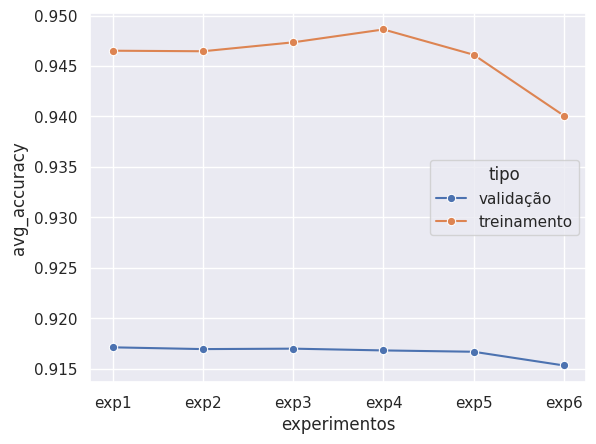

In [29]:
val_avg_acc = [r['avg_results']['accuracy'] for r in results_list]
train_avg_acc = [r['avg_results_train']['accuracy'] for r in results_list]

dict_results_for_plot = {'avg_accuracy': val_avg_acc,
                         'experimentos': ['exp1', 'exp2', 'exp3', 'exp4', 'exp5', 'exp6'],
                         'tipo': ['validação']*6}

dict_results_for_plot_train = {'avg_accuracy': train_avg_acc,
                               'experimentos': ['exp1', 'exp2', 'exp3', 'exp4', 'exp5', 'exp6'],
                               'tipo': ['treinamento']*6}

df_plot_val = pd.DataFrame(dict_results_for_plot)
df_plot_train = pd.DataFrame(dict_results_for_plot_train)
df_plot = pd.concat([df_plot_val, df_plot_train], axis=0)

sns.lineplot(data=df_plot, x='experimentos', y='avg_accuracy', hue='tipo', markers=True, marker='o')
plt.plot()

- Aqui podemos ver a matriz de confusão normalizada média do modelo e pré-processamento escolhidos (LGBM com pré-processamento com configuração 1).

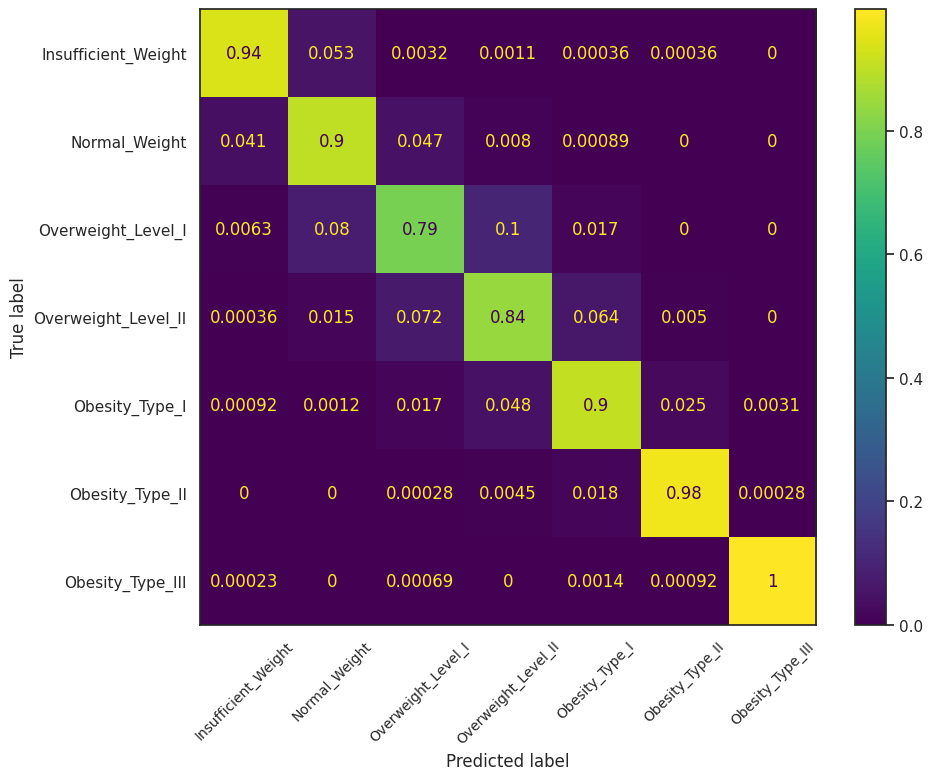

In [49]:
sns.set_theme(style='white')

fig, axes = plt.subplots(figsize=(10, 8))

disp = ConfusionMatrixDisplay(confusion_matrix=results_list[0]['avg_confusion_matrix'], 
                              display_labels=['Insufficient_Weight', 'Normal_Weight', 
                                              'Overweight_Level_I', 'Overweight_Level_II', 
                                              'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III'])
disp.plot(ax=axes)
axes.tick_params(axis='x', labelsize=10, labelrotation=45)
plt.show()


- Box-plot do resultado da validação cruzada.
- Podemos ver que o modelo não apresenta uma grande variabilidade da acurácia na validação cruzada.

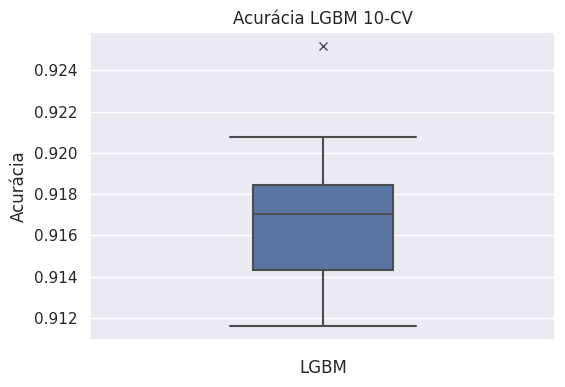

In [42]:
accs = []
sns.set_theme(style='darkgrid')
for fold in results_list[0]['fold_results']:
    accs.append(fold['accuracy']) 

fig, axes = plt.subplots(figsize=(6, 4))
sns.boxplot(y=accs,  linewidth=1.5, widths=.3, flierprops={"marker": "x"}, ax=axes)
axes.set_ylabel('Acurácia')
axes.set_xlabel('LGBM')
axes.set_title('Acurácia LGBM 10-CV')
plt.show()

- Valores dos resultados médios para cada classe.

In [37]:
import copy

results_list_mod = copy.deepcopy(results_list)
targets = ['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III']

for i, target in enumerate(targets):
    results_list_mod [0]['avg_results'][target] = results_list_mod [0]['avg_results'].pop(str(i))

pd.DataFrame(results_list_mod[0]['avg_results'], columns=['Insufficient_Weight', 'Normal_Weight', 
                                              'Overweight_Level_I', 'Overweight_Level_II', 
                                              'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III']).T

,precision,recall,f1-score
Insufficient_Weight,0.942834,0.941577,0.942108
Normal_Weight,0.880875,0.902796,0.891635
Overweight_Level_I,0.833264,0.794301,0.813212
Overweight_Level_II,0.831751,0.844248,0.837787
Obesity_Type_I,0.908033,0.904319,0.906020
Obesity_Type_II,0.972262,0.976587,0.974373
Obesity_Type_III,0.997482,0.996796,0.997138


- Portanto foi escolhido o modelo LGBM, com hiperparâmetros definidos através do Optuna e configuração 1 de pré-processamento.
- Modelo apresentou uma acurácia média no 10-fold cross validation de 0.9171370431543571.

## Test

- Para submissão do desafio do Kaggle o modelo foi treinado com todos os dados.

In [43]:
data_test_path = Path('data/test.csv')
data_test = pd.read_csv(data_test_path)

In [46]:
model_params = {"objective": "multiclass",
                "metric": "multi_logloss",
                "n_estimators": 1000,
                "verbose": -1,
                "bagging_freq": 1,
                'learning_rate': 0.008761898503537986, 
                'num_leaves': 21, 
                'subsample': 0.5253186918479049, 
                'colsample_bytree': 0.5446690373879486, 
                'min_data_in_leaf': 66,
                'importance_type': 'split'}


x_train = pipe1.fit_transform(x)
x_test_trans = pipe1.transform(data_test)


lgbm = LGBMClassifier(**model_params)
lgbm.fit(x_train, y)

LGBMClassifier(bagging_freq=1, colsample_bytree=0.5446690373879486,
               learning_rate=0.008761898503537986, metric='multi_logloss',
               min_data_in_leaf=66, n_estimators=1000, num_leaves=21,
               objective='multiclass', subsample=0.5253186918479049,
               verbose=-1)

#### Importância das features segundo o "split" e o "gain" do modelo.

- Vemos que o peso, altura e idade são considerados os mais importantes neste modelo utilizado.

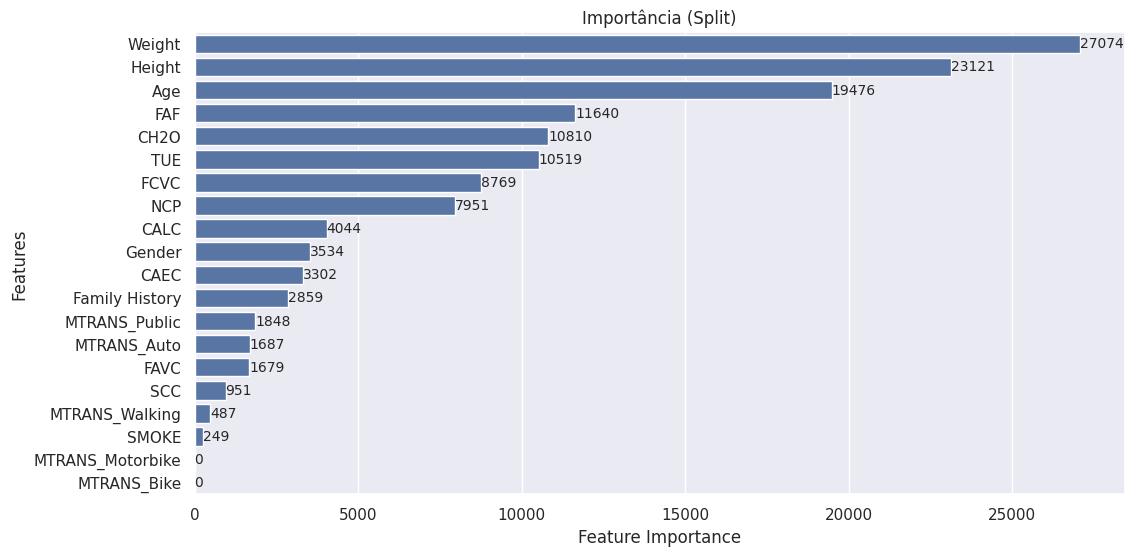

In [47]:
fp = lgbm.feature_importances_
fp_df = pd.DataFrame({'Features': ['CAEC', 'CALC', 'Gender', 'Family History', 
                                   'FAVC', 'SMOKE', 'SCC', 'MTRANS_Auto', 'MTRANS_Bike', 'MTRANS_Motorbike', 'MTRANS_Public',
                                   'MTRANS_Walking', 'Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE'], 'Feature Importance': fp })

fp_df = fp_df.sort_values(by=['Feature Importance'], ascending=False)

fig, ax = plt.subplots(figsize=(12, 6))

ax = sns.barplot(fp_df, x="Feature Importance", y="Features")
ax.bar_label(ax.containers[0], fontsize=10)
ax.set_title('Importância (Split)')
plt.show()

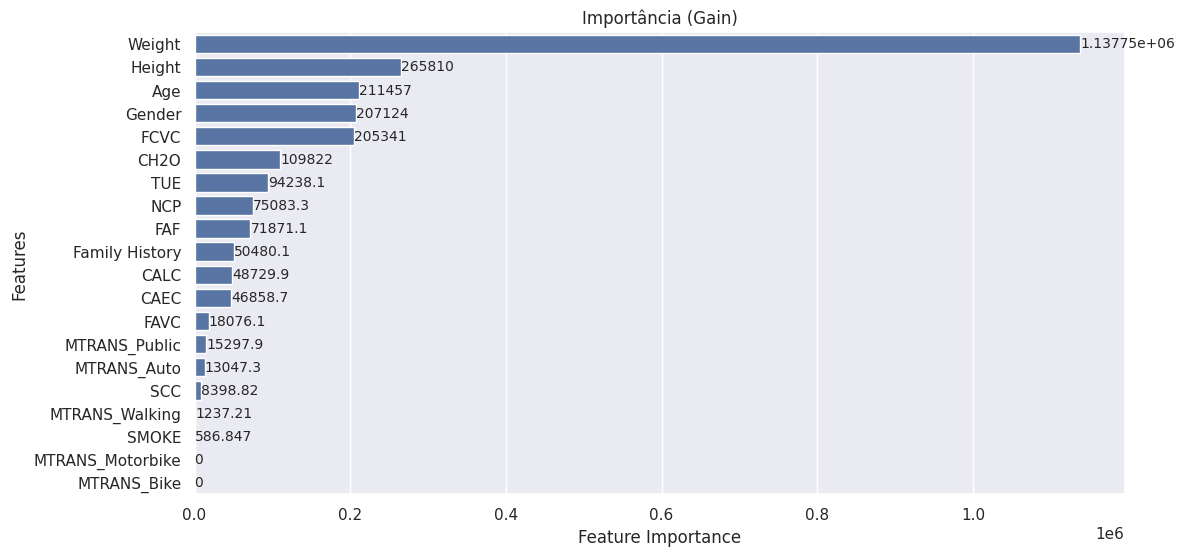

In [45]:
fp = lgbm.feature_importances_
fp_df = pd.DataFrame({'Features': ['CAEC', 'CALC', 'Gender', 'Family History', 
                                   'FAVC', 'SMOKE', 'SCC', 'MTRANS_Auto', 'MTRANS_Bike', 'MTRANS_Motorbike', 'MTRANS_Public',
                                   'MTRANS_Walking', 'Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE'], 'Feature Importance': fp })

fp_df = fp_df.sort_values(by=['Feature Importance'], ascending=False)

fig, ax = plt.subplots(figsize=(12, 6))

ax = sns.barplot(fp_df, x="Feature Importance", y="Features")
ax.bar_label(ax.containers[0], fontsize=10)
ax.set_title('Importância (Gain)')
plt.show()

### Kaggle

- Modelo utilizado nos dados de teste da competição e submetido ao kaggle.
- Resultados obtidos: 
    - Private score: 0.90832
    - Public score: 0.91546

In [51]:
y_test_pred = lgbm.predict(x_test_trans)
y_test_pred_names = [inverse_labels_mapping[i] for i in y_test_pred]

test_output_dict = {'id': data_test['id'].to_list(), 'NObeyesdad': y_test_pred_names}

test_output = pd.DataFrame(test_output_dict)


In [52]:
test_output.to_csv('sub1.csv', index=False)